## FER $\mapsto$ MongoDB

In this notebook we will implement a step-by-step procedure to **load & store** the `FER` dataset into **MongoDB**.
In particular, the dataset will be saved into the `learning_machine` db, a `fer` collection!

The basic general idea of this procedure is to make sure that all the steps are reproducible and (more importantly) cross-platform (e.g. Mac to Linux).

In [1]:
import sys
sys.path.append('../..')  # importing data from data module

### Loading data as `torch` Dataset

In [2]:
from torch.utils.data import DataLoader
from dataset import KaggleDataset

In [3]:
from dataset import DATA_FOLDER

In [4]:
DATA_FOLDER

'/Users/gu19087/Research/UoB/repos/WeTheCurious/wtc_github/learning_machine/backend/data'

In [5]:
# Reshare transformer to have images as 48x48 ndarray

from transforms import Reshape

In [6]:
dataset = KaggleDataset(transform=Reshape())

# collate_fn as Identity, i.e. list of `Sample` instances
kaggle_data_loader = DataLoader(dataset, batch_size=4, collate_fn=lambda b: b)

In [7]:
data_iter = iter(kaggle_data_loader)
batch = next(data_iter)

In [8]:
b = batch[0]

In [9]:
batch

[{'image': '... (len: 8287)', 'emotion': 0, 'emotion_label': 'Angry', 'set': 'training'},
 {'image': '... (len: 8687)', 'emotion': 0, 'emotion_label': 'Angry', 'set': 'training'},
 {'image': '... (len: 8581)', 'emotion': 2, 'emotion_label': 'Fear', 'set': 'training'},
 {'image': '... (len: 8555)', 'emotion': 4, 'emotion_label': 'Sad', 'set': 'training'}]

### Connecting to MongoDB

In [10]:
from pymongo import MongoClient

In [11]:
client = MongoClient()

In [12]:
db = client.learning_machine

In [13]:
faces = db.kaggle_faces

In [14]:
db.list_collection_names()

['kaggle_faces']

In [15]:
def to_json_collation(batch):
    if len(batch) == 1:
        b = batch[0]
        return b.to_json()
    return [s.to_json() for s in batch]

In [16]:
data_loader = DataLoader(dataset, batch_size=1, collate_fn=to_json_collation)
data_iter = iter(data_loader)

In [17]:
face = next(data_iter)

In [18]:
type(face)

dict

In [19]:
face.keys()

dict_keys(['image', 'emotion', 'emotion_label', 'set'])

In [20]:
%matplotlib inline

from matplotlib import pyplot as plt

In [21]:
import numpy as np


img = np.fromstring(face['image'], dtype=np.uint8, sep=' ')
img = img.reshape(48, 48)

In [22]:
img.shape

(48, 48)

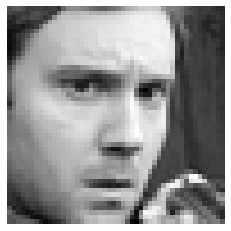

In [23]:
plt.imshow(img, cmap=plt.cm.gray)
plt.axis(False)
plt.show()

In [24]:
faces.insert_one(face)

In [25]:
[type(face[k]) for k in face]

[str, int, str, str, bson.objectid.ObjectId]

### Bulk Insert of Images in MongoDB

In [27]:
db.list_collection_names()

['kaggle_faces']

In [28]:
db.drop_collection('kaggle_faces')

{'nIndexesWas': 1, 'ns': 'learning_machine.kaggle_faces', 'ok': 1.0}

In [29]:
db.list_collection_names()

[]

In [30]:
data_loader = DataLoader(dataset, batch_size=16, collate_fn=to_json_collation, num_workers=4)
data_iter = iter(data_loader)

In [31]:
faces = db.kaggle_faces

In [32]:
for batch in data_iter:
    faces.insert_many(batch)

In [33]:
db.list_collection_names()

['kaggle_faces']

#### Verify Statistics

In [38]:
faces.count_documents({})

35887

In [39]:
faces.count_documents({'set': 'training'})

28709

In [40]:
faces.count_documents({'set': 'validation'})

3589

In [41]:
faces.count_documents({'set': 'test'})

3589

In [43]:
from dataset import Sample

emotion_labels = Sample.EMOTION_MAP.values()

In [44]:
emotion_labels

dict_values(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

In [46]:
for emotion in emotion_labels:
    emo_count = {}
    for dset in ['training', 'validation', 'test']:
        c = faces.count_documents({'set': dset, 'emotion_label': emotion})
        emo_count[dset] = c
    print('Faces for {}: {} (TOTAL)'.format(emotion, sum(emo_count.values())))
    for dset, count in emo_count.items(): 
        print('\t {}: {}'.format(dset, count))

Faces for Angry: 4953 (TOTAL)
	 training: 3995
	 validation: 491
	 test: 467
Faces for Disgust: 547 (TOTAL)
	 training: 436
	 validation: 55
	 test: 56
Faces for Fear: 5121 (TOTAL)
	 training: 4097
	 validation: 528
	 test: 496
Faces for Happy: 8989 (TOTAL)
	 training: 7215
	 validation: 879
	 test: 895
Faces for Sad: 6077 (TOTAL)
	 training: 4830
	 validation: 594
	 test: 653
Faces for Surprise: 4002 (TOTAL)
	 training: 3171
	 validation: 416
	 test: 415
Faces for Neutral: 6198 (TOTAL)
	 training: 4965
	 validation: 626
	 test: 607
